# PCoE LightGBM

[PCoE][pcoe]の No.6 Turbofan Engine Degradation Simulation Dataset FD001に対して [LightGM][lightgbm]を[Optuna][optuna]で最適化する実験。

[lightgbm]: https://lightgbm.readthedocs.io/en/latest/
[optuna]: https://optuna.readthedocs.io/en/stable/index.html
[pcoe]: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/


# Install Optuna

In [ ]:
try:
    import optuna
except ModuleNotFoundError:
    # https://optuna.readthedocs.io/en/stable/installation.html
    !pip install optuna

import optuna
from optuna.integration.lightgbm import Dataset, LightGBMTunerCV

     |████████████████████████████████| 296kB 16.2MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 1.2MB 50.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 143kB 51.3MB/s 
     |████████████████████████████████| 112kB 39.0MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
  Created wheel for alembic: filename=alembic-1.6.2-py2.py3-none-any.whl size=164219 sha256=b702b5dea2a7c44f85bbb7bd3f197609bfcda37fbac4f155b812a7cd0da274fe
  Stored in directory: /root/.cache/pip/wheels/a5/63/44/db29401e49ef5331c163b591f12a465c40af864bfa888dabd2
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=b0addad2b6e1145a9f0976ea0c20cfea736a79300c2415b584a082d4a19a382e
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built alembic pyperclip


# Preset

In [ ]:
# default packages
import logging
import pprint
from pathlib import Path
from typing import Any, Dict, Generator, List, Sequence, Tuple
from zipfile import ZipFile

In [ ]:
# third party packages
import IPython.display as display
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tqdm.autonotebook as tqdm
from lightgbm import Booster
from pandas import DataFrame, Series
from sklearn.model_selection import KFold

In [ ]:
# mode
MODE_DEBUG = True

In [ ]:
# logger
_logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG if MODE_DEBUG else logging.INFO)

In [ ]:
# seaborn
sns.set()

# Global parameters

In [ ]:
PATH_ARCHIVE = Path("turbofun.zip")
PATH_EXTRACT = Path("turbofun")

In [ ]:
# 利用する変数を定義
COLUMNS_ALL = [
    *[f"op{i:02}" for i in range(3)],
    *[f"sensor{i:02}" for i in range(26)],
]
COLUMNS_INVALID = [
    "op02",
    "sensor01",
    "sensor04",
    "sensor09",
    "sensor15",
    "sensor17",
    "sensor18",
    "sensor21",
    "sensor22",
    "sensor23",
    "sensor24",
    "sensor25",
]
COLUMNS_VALID = sorted(list(set(COLUMNS_ALL) - set(COLUMNS_INVALID)))

COLUMNS_TARGET = ["rul"]

# Load dataset

In [ ]:
def download(filename: Path) -> None:
    """zipファイルをダウンロード."""
    if filename.exists():
        return

    url = "https://ti.arc.nasa.gov/c/6/"
    res = requests.get(url, stream=True)
    if res.status_code != 200:
        _logger.error(res.status_code)
        return

    with open(filename, "wb") as f:
        for chunk in tqdm.tqdm(res):
            f.write(chunk)


download(PATH_ARCHIVE)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): ti.arc.nasa.gov:443
DEBUG:urllib3.connectionpool:https://ti.arc.nasa.gov:443 "GET /c/6/ HTTP/1.1" 302 0
DEBUG:urllib3.connectionpool:https://ti.arc.nasa.gov:443 "GET /m/project/prognostic-repository/CMAPSSData.zip HTTP/1.1" 200 12425978


In [ ]:
def extractall(src: Path, dst: Path) -> None:
    """zipファイルを解凍."""
    if not src.exists():
        _logger.error(f"{src} does not exist.")
        return
    if dst.exists():
        _logger.error(f"{dst} exists.")
        return

    with ZipFile(src) as zf:
        zf.extractall(dst)


extractall(PATH_ARCHIVE, PATH_EXTRACT)

In [ ]:
def load_data(filename: Path) -> DataFrame:
    """データを読み取り、1セルに1unit分のデータをnumpy.arrayで保持するDataFrameとする."""
    df = pd.read_csv(
        filename,
        header=None,
        sep=" ",
        names=[
            "unit",
            "time",
            *[f"op{i:02d}" for i in range(3)],
            *[f"sensor{i:02d}" for i in range(26)],
        ],
    )
    df = df.astype({
        c: "float32"
        for c in [
            *[f"op{i:02d}" for i in range(3)],
            *[f"sensor{i:02d}" for i in range(26)],
        ]
    })

    return df


DF_TRAIN = load_data(PATH_EXTRACT.joinpath("train_FD001.txt"))
DF_TEST = load_data(PATH_EXTRACT.joinpath("test_FD001.txt"))

In [ ]:
display.display(DF_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,-0.0007,-0.0004,100.0,518.669983,641.820007,1589.699951,1400.599976,14.62,21.610001,554.359985,2388.060059,9046.190430,1.3,47.470001,521.659973,2388.020020,8138.620117,8.4195,0.03,392.0,2388.0,100.0,39.060001,23.419001,NaN,NaN,NaN,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.669983,642.150024,1591.819946,1403.140015,14.62,21.610001,553.750000,2388.040039,9044.070312,1.3,47.490002,522.280029,2388.070068,8131.490234,8.4318,0.03,392.0,2388.0,100.0,39.000000,23.423599,NaN,NaN,NaN,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.669983,642.349976,1587.989990,1404.199951,14.62,21.610001,554.260010,2388.080078,9052.940430,1.3,47.270000,522.419983,2388.030029,8133.229980,8.4178,0.03,390.0,2388.0,100.0,38.950001,23.344200,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.669983,642.349976,1582.790039,1401.869995,14.62,21.610001,554.450012,2388.110107,9049.480469,1.3,47.130001,522.859985,2388.080078,8133.830078,8.3682,0.03,392.0,2388.0,100.0,38.880001,23.373899,NaN,NaN,NaN,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.669983,642.369995,1582.849976,1406.219971,14.62,21.610001,554.000000,2388.060059,9055.150391,1.3,47.279999,522.190002,2388.040039,8133.799805,8.4294,0.03,393.0,2388.0,100.0,38.900002,23.404400,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.669983,643.489990,1597.979980,1428.630005,14.62,21.610001,551.429993,2388.189941,9065.519531,1.3,48.070000,519.489990,2388.260010,8137.600098,8.4956,0.03,397.0,2388.0,100.0,38.490002,22.973499,NaN,NaN,NaN,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.669983,643.539978,1604.500000,1433.579956,14.62,21.610001,550.859985,2388.229980,9065.110352,1.3,48.040001,519.679993,2388.219971,8136.500000,8.5139,0.03,395.0,2388.0,100.0,38.299999,23.159401,NaN,NaN,NaN,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.669983,643.419983,1602.459961,1428.180054,14.62,21.610001,550.940002,2388.239990,9065.900391,1.3,48.090000,520.010010,2388.239990,8141.049805,8.5646,0.03,398.0,2388.0,100.0,38.439999,22.933300,NaN,NaN,NaN,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.669983,643.229980,1605.260010,1426.530029,14.62,21.610001,550.679993,2388.250000,9073.719727,1.3,48.389999,519.669983,2388.229980,8139.290039,8.5389,0.03,395.0,2388.0,100.0,38.290001,23.063999,NaN,NaN,NaN,NaN,NaN


In [ ]:
display.display(DF_TEST)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,0.0023,0.0003,100.0,518.669983,643.020020,1585.290039,1398.209961,14.62,21.610001,553.900024,2388.040039,9050.169922,1.3,47.200001,521.719971,2388.030029,8125.549805,8.4052,0.03,392.0,2388.0,100.0,38.860001,23.373501,NaN,NaN,NaN,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.669983,641.710022,1588.449951,1395.420044,14.62,21.610001,554.849976,2388.010010,9054.419922,1.3,47.500000,522.159973,2388.060059,8139.620117,8.3803,0.03,393.0,2388.0,100.0,39.020000,23.391600,NaN,NaN,NaN,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.669983,642.460022,1586.939941,1401.339966,14.62,21.610001,554.109985,2388.050049,9056.959961,1.3,47.500000,521.969971,2388.030029,8130.100098,8.4441,0.03,393.0,2388.0,100.0,39.080002,23.416599,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.669983,642.440002,1584.119995,1406.420044,14.62,21.610001,554.070007,2388.030029,9045.290039,1.3,47.279999,521.380005,2388.050049,8132.899902,8.3917,0.03,391.0,2388.0,100.0,39.000000,23.373699,NaN,NaN,NaN,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.669983,642.510010,1587.189941,1401.920044,14.62,21.610001,554.159973,2388.010010,9044.549805,1.3,47.310001,522.150024,2388.030029,8129.540039,8.4031,0.03,390.0,2388.0,100.0,38.990002,23.413000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.669983,643.239990,1599.449951,1415.790039,14.62,21.610001,553.409973,2388.020020,9142.370117,1.3,47.689999,520.690002,2388.000000,8213.280273,8.4715,0.03,394.0,2388.0,100.0,38.650002,23.197399,NaN,NaN,NaN,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.669983,643.219971,1595.689941,1422.050049,14.62,21.610001,553.219971,2388.050049,9140.679688,1.3,47.599998,521.049988,2388.090088,8210.849609,8.4512,0.03,395.0,2388.0,100.0,38.570000,23.277100,NaN,NaN,NaN,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.669983,643.440002,1593.150024,1406.819946,14.62,21.610001,553.039978,2388.110107,9146.809570,1.3,47.570000,521.179993,2388.040039,8217.240234,8.4569,0.03,395.0,2388.0,100.0,38.619999,23.205099,NaN,NaN,NaN,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.669983,643.260010,1594.989990,1419.359985,14.62,21.610001,553.369995,2388.070068,9148.849609,1.3,47.610001,521.330017,2388.080078,8220.480469,8.4711,0.03,395.0,2388.0,100.0,38.660000,23.269899,NaN,NaN,NaN,NaN,NaN


In [ ]:
def create_train_rul(df: DataFrame) -> Series:
    """学習データに対するRULを算出する."""
    df_rul = df.copy()
    df_max_time = df.groupby(["unit"])["time"].max()
    df_rul["rul"] = df_rul.apply(
        lambda x: df_max_time.at[x["unit"]] - x["time"],
        axis=1,
    )
    df_rul = df_rul.astype({"rul": "float32"})

    return df_rul



DF_TRAIN = create_train_rul(DF_TRAIN)
display.display(DF_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,rul
0,1,1,-0.0007,-0.0004,100.0,518.669983,641.820007,1589.699951,1400.599976,14.62,21.610001,554.359985,2388.060059,9046.190430,1.3,47.470001,521.659973,2388.020020,8138.620117,8.4195,0.03,392.0,2388.0,100.0,39.060001,23.419001,NaN,NaN,NaN,NaN,NaN,191.0
1,1,2,0.0019,-0.0003,100.0,518.669983,642.150024,1591.819946,1403.140015,14.62,21.610001,553.750000,2388.040039,9044.070312,1.3,47.490002,522.280029,2388.070068,8131.490234,8.4318,0.03,392.0,2388.0,100.0,39.000000,23.423599,NaN,NaN,NaN,NaN,NaN,190.0
2,1,3,-0.0043,0.0003,100.0,518.669983,642.349976,1587.989990,1404.199951,14.62,21.610001,554.260010,2388.080078,9052.940430,1.3,47.270000,522.419983,2388.030029,8133.229980,8.4178,0.03,390.0,2388.0,100.0,38.950001,23.344200,NaN,NaN,NaN,NaN,NaN,189.0
3,1,4,0.0007,0.0000,100.0,518.669983,642.349976,1582.790039,1401.869995,14.62,21.610001,554.450012,2388.110107,9049.480469,1.3,47.130001,522.859985,2388.080078,8133.830078,8.3682,0.03,392.0,2388.0,100.0,38.880001,23.373899,NaN,NaN,NaN,NaN,NaN,188.0
4,1,5,-0.0019,-0.0002,100.0,518.669983,642.369995,1582.849976,1406.219971,14.62,21.610001,554.000000,2388.060059,9055.150391,1.3,47.279999,522.190002,2388.040039,8133.799805,8.4294,0.03,393.0,2388.0,100.0,38.900002,23.404400,NaN,NaN,NaN,NaN,NaN,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.669983,643.489990,1597.979980,1428.630005,14.62,21.610001,551.429993,2388.189941,9065.519531,1.3,48.070000,519.489990,2388.260010,8137.600098,8.4956,0.03,397.0,2388.0,100.0,38.490002,22.973499,NaN,NaN,NaN,NaN,NaN,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.669983,643.539978,1604.500000,1433.579956,14.62,21.610001,550.859985,2388.229980,9065.110352,1.3,48.040001,519.679993,2388.219971,8136.500000,8.5139,0.03,395.0,2388.0,100.0,38.299999,23.159401,NaN,NaN,NaN,NaN,NaN,3.0
20628,100,198,0.0004,0.0000,100.0,518.669983,643.419983,1602.459961,1428.180054,14.62,21.610001,550.940002,2388.239990,9065.900391,1.3,48.090000,520.010010,2388.239990,8141.049805,8.5646,0.03,398.0,2388.0,100.0,38.439999,22.933300,NaN,NaN,NaN,NaN,NaN,2.0
20629,100,199,-0.0011,0.0003,100.0,518.669983,643.229980,1605.260010,1426.530029,14.62,21.610001,550.679993,2388.250000,9073.719727,1.3,48.389999,519.669983,2388.229980,8139.290039,8.5389,0.03,395.0,2388.0,100.0,38.290001,23.063999,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
def load_rul(df: DataFrame, filepath: Path) -> DataFrame:
    """テスト用のRULを読み込み、元のDFにRULを追加する."""
    df_test = df.copy()

    df_rul = pd.read_csv(
        filepath,
        header=None,
        sep=" ",
        names=["rul", "none"],
    )
    df_rul.drop(["none"], axis=1, inplace=True)
    df_rul["unit"] = range(1, len(df_rul) + 1)
    df_rul.set_index(["unit"], inplace=True)

    df_max_time = df.groupby(["unit"])["time"].max()
    df_test["rul"] = df_test.apply(
        lambda x: df_rul.at[x["unit"], "rul"] + df_max_time.at[x["unit"]] - x["time"],
        axis=1,
    )
    df_test = df_test.astype({"rul": "float32"})

    return df_test


DF_TEST = load_rul(DF_TEST, PATH_EXTRACT.joinpath("RUL_FD001.txt"))
display.display(DF_TEST)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,rul
0,1,1,0.0023,0.0003,100.0,518.669983,643.020020,1585.290039,1398.209961,14.62,21.610001,553.900024,2388.040039,9050.169922,1.3,47.200001,521.719971,2388.030029,8125.549805,8.4052,0.03,392.0,2388.0,100.0,38.860001,23.373501,NaN,NaN,NaN,NaN,NaN,142.0
1,1,2,-0.0027,-0.0003,100.0,518.669983,641.710022,1588.449951,1395.420044,14.62,21.610001,554.849976,2388.010010,9054.419922,1.3,47.500000,522.159973,2388.060059,8139.620117,8.3803,0.03,393.0,2388.0,100.0,39.020000,23.391600,NaN,NaN,NaN,NaN,NaN,141.0
2,1,3,0.0003,0.0001,100.0,518.669983,642.460022,1586.939941,1401.339966,14.62,21.610001,554.109985,2388.050049,9056.959961,1.3,47.500000,521.969971,2388.030029,8130.100098,8.4441,0.03,393.0,2388.0,100.0,39.080002,23.416599,NaN,NaN,NaN,NaN,NaN,140.0
3,1,4,0.0042,0.0000,100.0,518.669983,642.440002,1584.119995,1406.420044,14.62,21.610001,554.070007,2388.030029,9045.290039,1.3,47.279999,521.380005,2388.050049,8132.899902,8.3917,0.03,391.0,2388.0,100.0,39.000000,23.373699,NaN,NaN,NaN,NaN,NaN,139.0
4,1,5,0.0014,0.0000,100.0,518.669983,642.510010,1587.189941,1401.920044,14.62,21.610001,554.159973,2388.010010,9044.549805,1.3,47.310001,522.150024,2388.030029,8129.540039,8.4031,0.03,390.0,2388.0,100.0,38.990002,23.413000,NaN,NaN,NaN,NaN,NaN,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.669983,643.239990,1599.449951,1415.790039,14.62,21.610001,553.409973,2388.020020,9142.370117,1.3,47.689999,520.690002,2388.000000,8213.280273,8.4715,0.03,394.0,2388.0,100.0,38.650002,23.197399,NaN,NaN,NaN,NaN,NaN,24.0
13092,100,195,-0.0011,-0.0001,100.0,518.669983,643.219971,1595.689941,1422.050049,14.62,21.610001,553.219971,2388.050049,9140.679688,1.3,47.599998,521.049988,2388.090088,8210.849609,8.4512,0.03,395.0,2388.0,100.0,38.570000,23.277100,NaN,NaN,NaN,NaN,NaN,23.0
13093,100,196,-0.0006,-0.0003,100.0,518.669983,643.440002,1593.150024,1406.819946,14.62,21.610001,553.039978,2388.110107,9146.809570,1.3,47.570000,521.179993,2388.040039,8217.240234,8.4569,0.03,395.0,2388.0,100.0,38.619999,23.205099,NaN,NaN,NaN,NaN,NaN,22.0
13094,100,197,-0.0038,0.0001,100.0,518.669983,643.260010,1594.989990,1419.359985,14.62,21.610001,553.369995,2388.070068,9148.849609,1.3,47.610001,521.330017,2388.080078,8220.480469,8.4711,0.03,395.0,2388.0,100.0,38.660000,23.269899,NaN,NaN,NaN,NaN,NaN,21.0


In [ ]:
def split_last(df: DataFrame) -> DataFrame:
    """各ユニットの最終行のみ返す."""
    df_last = df.groupby(["unit"]).apply(lambda x: x.loc[x["time"] == x["time"].max()])
    df_last.drop(["unit"], axis=1, inplace=True)
    df_last.reset_index(inplace=True)
    df_last.drop(["level_1"], axis=1, inplace=True)

    return df_last


DF_TEST_LAST = split_last(DF_TEST)
display.display(DF_TEST_LAST)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,rul
0,1,31,-0.0006,0.0004,100.0,518.669983,642.580017,1581.219971,1398.910034,14.62,21.610001,554.419983,2388.080078,9056.400391,1.3,47.230000,521.789978,2388.060059,8130.109863,8.4024,0.03,393.0,2388.0,100.0,38.810001,23.355200,NaN,NaN,NaN,NaN,NaN,112.0
1,2,49,0.0018,-0.0001,100.0,518.669983,642.549988,1586.589966,1410.829956,14.62,21.610001,553.520020,2388.100098,9044.769531,1.3,47.669998,521.739990,2388.090088,8126.899902,8.4505,0.03,391.0,2388.0,100.0,38.810001,23.261801,NaN,NaN,NaN,NaN,NaN,98.0
2,3,126,-0.0016,0.0004,100.0,518.669983,642.880005,1589.750000,1418.890015,14.62,21.610001,552.590027,2388.159912,9049.259766,1.3,47.880001,520.830017,2388.139893,8131.459961,8.4119,0.03,395.0,2388.0,100.0,38.930000,23.274000,NaN,NaN,NaN,NaN,NaN,69.0
3,4,106,0.0012,0.0004,100.0,518.669983,642.780029,1594.530029,1406.880005,14.62,21.610001,552.640015,2388.129883,9051.299805,1.3,47.650002,521.880005,2388.110107,8133.640137,8.4634,0.03,395.0,2388.0,100.0,38.580002,23.258101,NaN,NaN,NaN,NaN,NaN,82.0
4,5,98,-0.0013,-0.0004,100.0,518.669983,642.270020,1589.939941,1419.359985,14.62,21.610001,553.289978,2388.100098,9053.990234,1.3,47.459999,521.000000,2388.149902,8125.740234,8.4362,0.03,394.0,2388.0,100.0,38.750000,23.411699,NaN,NaN,NaN,NaN,NaN,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,518.669983,642.299988,1590.880005,1397.939941,14.62,21.610001,553.989990,2388.030029,9062.410156,1.3,47.139999,522.299988,2388.010010,8148.240234,8.4110,0.03,391.0,2388.0,100.0,38.959999,23.460600,NaN,NaN,NaN,NaN,NaN,137.0
96,97,134,0.0013,-0.0001,100.0,518.669983,642.590027,1582.959961,1410.920044,14.62,21.610001,554.049988,2388.060059,9076.360352,1.3,47.380001,521.580017,2388.060059,8155.479980,8.4500,0.03,395.0,2388.0,100.0,38.610001,23.295300,NaN,NaN,NaN,NaN,NaN,82.0
97,98,121,0.0017,0.0001,100.0,518.669983,642.679993,1599.510010,1415.469971,14.62,21.610001,553.440002,2388.129883,9062.339844,1.3,47.660000,521.530029,2388.090088,8146.390137,8.4235,0.03,394.0,2388.0,100.0,38.759998,23.360800,NaN,NaN,NaN,NaN,NaN,59.0
98,99,97,0.0047,-0.0000,100.0,518.669983,642.000000,1585.030029,1397.979980,14.62,21.610001,554.750000,2388.010010,9067.160156,1.3,47.259998,521.820007,2388.020020,8150.379883,8.4003,0.03,391.0,2388.0,100.0,38.950001,23.359501,NaN,NaN,NaN,NaN,NaN,117.0


# LightGBM

In [ ]:
class KFoldUnits:
    """事前に設定したデータセットのインデックスに対してunitを基準に分割する."""
    def __init__(self, df: DataFrame, n_splits: int, random_state: int):
        self.units = df["unit"]
        self.unique_units = self.units.unique()
        self.kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    def split(self, X, y = None, groups = None) -> Generator[Tuple[List[int], List[int]], None, None]:
        for idx_train, idx_test in self.kfold.split(self.unique_units):
            units_train = self.unique_units[idx_train]
            units_test = self.unique_units[idx_test]
            idx_df_train = self.units.index[self.units.isin(units_train)].tolist()
            idx_df_test = self.units.index[self.units.isin(units_test)].tolist()
            yield idx_df_train, idx_df_test

In [ ]:
def fit(df: DataFrame, cols: List[str], target: str) -> Any:
    """学習する."""
    dataset_train = Dataset(df[cols], label=df[target])
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
    }

    folds = KFoldUnits(df, n_splits=5, random_state=42)
    study = optuna.create_study()
    tuner = LightGBMTunerCV(params, dataset_train, folds=folds)
    tuner.run()

    return tuner


TUNER = fit(DF_TRAIN, COLUMNS_VALID, COLUMNS_TARGET[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
_logger.info(f"best score: {TUNER.best_score}")
_logger.info(f"best parameter: {pprint.pformat(TUNER.best_params)}")

INFO:__main__:best score: 42.58870338530191
INFO:__main__:best parameter: {'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0015536319510391964,
 'lambda_l2': 2.0592030670448462,
 'metric': 'rmse',
 'min_child_samples': 100,
 'num_leaves': 3,
 'objective': 'regression'}


In [ ]:
def final_train(df: pd.DataFrame, params: Dict, cols: List[str], target: str) -> Booster:
    dataset_train = Dataset(df[cols], df[target])
    booster = lgb.train(params, dataset_train)

    return booster


FINAL_BOOSTER = final_train(DF_TRAIN, TUNER.best_params, COLUMNS_VALID, COLUMNS_TARGET[0])

## Results

In [ ]:
def evaluate(
    df: pd.DataFrame,
    booster: Booster,
    cols: List[str],
    target: str,
) -> DataFrame:
    result = booster.predict(df[cols])

    df_result = df[["unit", "time", target]].copy()
    df_result["pred"] = result

    return df_result

In [ ]:
DF_RESULT_TRAIN = evaluate(
    DF_TRAIN,
    FINAL_BOOSTER,
    COLUMNS_VALID,
    COLUMNS_TARGET[0],
)

In [ ]:
DF_RESULT_TEST = evaluate(
    DF_TEST,
    FINAL_BOOSTER,
    COLUMNS_VALID,
    COLUMNS_TARGET[0],
)

In [ ]:
DF_RESULT_TEST_LAST = evaluate(
    DF_TEST_LAST,
    FINAL_BOOSTER,
    COLUMNS_VALID,
    COLUMNS_TARGET[0],
)

In [ ]:
def show_metrics(df: DataFrame) -> None:
    rmse = np.sqrt(((df["rul"] - df["pred"]) ** 2).mean())

    _logger.info(f"rmse: {rmse}")
    display.display(df)

In [ ]:
show_metrics(DF_RESULT_TRAIN)

INFO:__main__:rmse: 41.51813256236851


,unit,time,rul,pred
0,1,1,191.0,169.896711
1,1,2,190.0,161.775483
2,1,3,189.0,170.792888
3,1,4,188.0,188.137336
4,1,5,187.0,159.300410
...,...,...,...,...
20626,100,196,4.0,12.486283
20627,100,197,3.0,12.638107
20628,100,198,2.0,10.739651
20629,100,199,1.0,10.852144


In [ ]:
show_metrics(DF_RESULT_TEST)

INFO:__main__:rmse: 45.968947066661975


,unit,time,rul,pred
0,1,1,142.0,178.789415
1,1,2,141.0,169.378468
2,1,3,140.0,160.898832
3,1,4,139.0,167.044782
4,1,5,138.0,180.781376
...,...,...,...,...
13091,100,194,24.0,29.102524
13092,100,195,23.0,37.011566
13093,100,196,22.0,44.768229
13094,100,197,21.0,36.433251


In [ ]:
show_metrics(DF_RESULT_TEST_LAST)

INFO:__main__:rmse: 31.923313928460676


,unit,time,rul,pred
0,1,31,112.0,173.879090
1,2,49,98.0,136.540522
2,3,126,69.0,79.848714
3,4,106,82.0,112.611266
4,5,98,91.0,112.101656
...,...,...,...,...
95,96,97,137.0,170.994938
96,97,134,82.0,82.176276
97,98,121,59.0,93.172894
98,99,97,117.0,153.551401


In [ ]:
def predict(df: DataFrame, units: List[int]) -> None:
    """予測結果を可視化する."""
    for unit in units:
        df_target = df[df["unit"] == unit]
        fig, axes = plt.subplots(1, 1, figsize=(9, 4), tight_layout=True)
        ax = axes
        ax.plot(df_target["time"], df_target["rul"], label="rul")
        ax.plot(df_target["time"], df_target["pred"], label="pred")
        ax.set_title(f"unit{unit:02}")
        plt.show()
        plt.close()
        fig.clf()

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 2.335
DEBUG

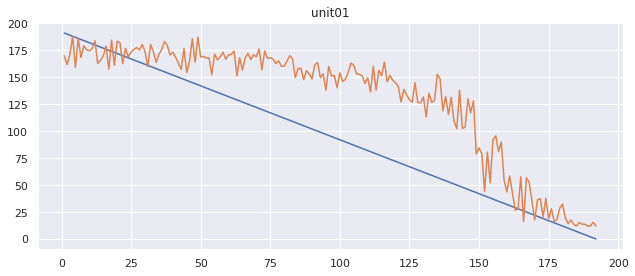

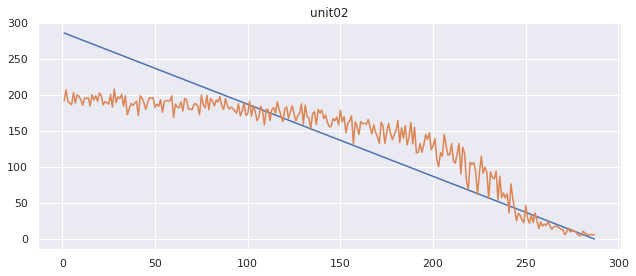

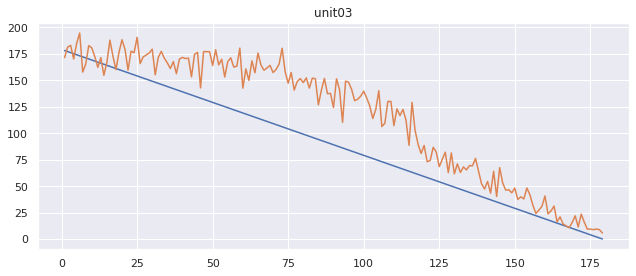

In [ ]:
predict(DF_RESULT_TRAIN, DF_RESULT_TRAIN["unit"].unique()[:3])

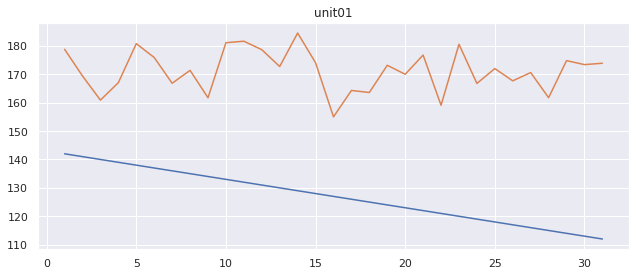

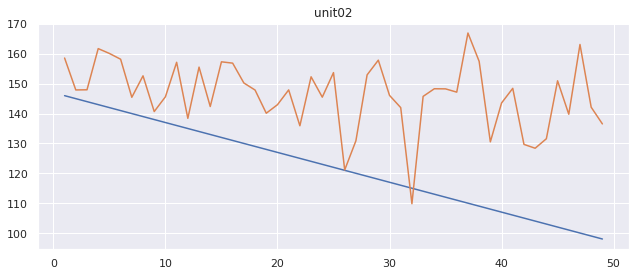

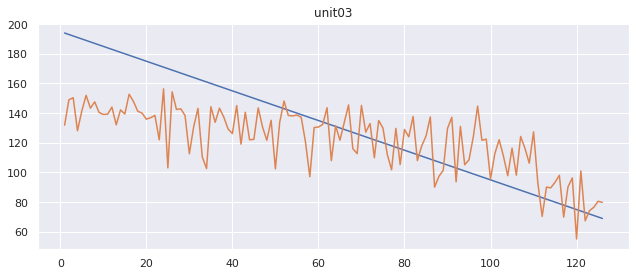

In [ ]:
predict(DF_RESULT_TEST, DF_RESULT_TEST["unit"].unique()[:3])

In [ ]:
# 特徴量重要度を確認
display.display(
    DataFrame(
        {
            "columns": COLUMNS_VALID,
            "value": FINAL_BOOSTER.feature_importance()
        }
    )
)

,columns,value
0,op00,0
1,op01,0
2,sensor00,0
3,sensor02,7
4,sensor03,21
5,sensor05,0
6,sensor06,14
7,sensor07,15
8,sensor08,27
9,sensor10,19
